<a href="https://colab.research.google.com/github/lilanpei/NMT/blob/master/NMT_Bi_GRU_%2B_Attention_%2B_Beam_search_%2B_BLEU_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tokenizing:

In [0]:
# from nltk.parse import CoreNLPParser
# parser = CoreNLPParser('http://localhost:9001')
# with open(r'H:\HLT\zh-Education.tok','w',encoding="utf-8") as cf:
#     with open(r'G:\NLP\zh-Education.txt','r',encoding="utf-8") as f:
#         for _ , line in enumerate(f):
#             cf.write((' '.join(list(parser.tokenize(line)))) + '\n')

In [0]:
# from nltk.parse import CoreNLPParser
# parser = CoreNLPParser('http://localhost:9001')
# with open(r'H:\HLT\en-Education.tok','w',encoding="utf-8") as cf:
#     with open(r'G:\NLP\en-Education.txt','r',encoding="utf-8") as f:
#         for _ , line in enumerate(f):
#             cf.write((' '.join(list(parser.tokenize(line)))) + '\n')

In [0]:
# For easy reset of notebook state.
import tensorflow as tf
from tensorflow.core.protobuf import rewriter_config_pb2
tf.keras.backend.clear_session()

config_proto = tf.compat.v1.ConfigProto()
off = rewriter_config_pb2.RewriterConfig.OFF
config_proto.graph_options.rewrite_options.arithmetic_optimization = off
session = tf.compat.v1.Session(config=config_proto)
tf.compat.v1.keras.backend.set_session(session)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import unicodedata
import re

# Preprocessing data
def unicodeToAscii(s): 
    # Turn a Unicode string to plain ASCII
    # refer to https://stackoverflow.com/a/518232/2809427
    return ''.join( c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def en_normalizeString(s):
    # lowercase, trim and remove non-letter characters
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"[^a-zA-Z0-9,.!?]+", r" ", s)
    s = s.strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    s = '<start> ' + s + ' <end>'
    return s

def zh_normalizeString(s):
    # lowercase, trim and remove non-letter characters
    s = s.lower().strip()
    s = re.sub(r"[^a-zA-Z0-9\u4e00-\u9fa5！？，。]+", r" ", s)
    s = s.strip()

    return s

In [0]:
import io

# Create input/target dataset
def create_dataset(path_zh, path_en, num_examples=None):
    chinese_sentences = io.open(path_zh, encoding='UTF-8').read().strip().split('\n')
    english_sentences = io.open(path_en, encoding='UTF-8').read().strip().split('\n')
    chinese_sentences = [zh_normalizeString(s) for s in chinese_sentences[:num_examples]]
    english_sentences = [en_normalizeString(s) for s in english_sentences[:num_examples]]  
    return chinese_sentences, english_sentences

In [7]:
import keras.preprocessing.text as T
import keras.preprocessing.sequence as S

# Tokening
def tokenize(lang):
    lang_tokenizer = T.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    
    return tensor, lang_tokenizer

Using TensorFlow backend.


In [0]:
# Transform word to index
def load_dataset(path_to_file_zh, path_to_file_en, num_examples=None):
    inp_lang, targ_lang  = create_dataset(path_to_file_zh, path_to_file_en, num_examples)
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [0]:
path_to_file_zh = r'/content/drive/My Drive/NLP/NMT/zh-Education.tok'
path_to_file_en = r'/content/drive/My Drive/NLP/NMT/en-Education.tok'

# Try experimenting with the size of that dataset
num_examples = 2000#450000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file_zh, path_to_file_en, num_examples)

# Creating a reverse dictionary (index to word)
index_word_inp = dict(map(reversed, inp_lang.word_index.items()))
index_word_targ = dict(map(reversed, targ_lang.word_index.items()))

In [10]:
# Input tokens for encoder zero padded
num_encoder_tokens = len(inp_lang.word_index) + 1
# Input tokens for decoder zero padded
num_decoder_tokens = len(targ_lang.word_index) + 1
print('Number of input tokens for encoder/decoder with zero padding: {}, {}'.format(num_encoder_tokens, num_decoder_tokens))

Number of input tokens for encoder/decoder with zero padding: 9254, 8078


In [0]:
inps, targs  = create_dataset(path_to_file_zh, path_to_file_en, num_examples)
tokens_zh = [[token for token in sents.split()] for sents in inps]
tokens_en = [[token for token in sents.split()] for sents in targs]

In [0]:
from gensim.models import FastText
vector_size = 100
fast_model_zh = FastText(tokens_zh, size=vector_size, window=10, min_count=1, sg=1, iter=20, negative=10)
fast_model_en = FastText(tokens_en, size=vector_size, window=10, min_count=1, sg=1, iter=20, negative=10)

In [0]:
import numpy as np

# Custumize the embedding vectors for the dataset with pre-trained embedding word vectors
def get_embedding_matrix(fast_model, word2index, vector_size, num_tokens):
    embedding_matrix = np.zeros((num_tokens, vector_size))

    for word, idx in word2index.items():
        try:
          word_vec = fast_model.wv.word_vec(word)
        except KeyError:
          print('Can not find word_vec', word)
        if word_vec is not None:
            embedding_matrix[idx] = word_vec
    return embedding_matrix

In [0]:
# Creating input embedding vectors
input_emb_matrix = get_embedding_matrix(fast_model_zh, inp_lang.word_index, vector_size, num_encoder_tokens)
# Save input embedding vectors
np.save(r'/content/drive/My Drive/NLP/input_emb_matrix', input_emb_matrix)
# Creating output embedding vectors
output_emb_matrix = get_embedding_matrix(fast_model_en, targ_lang.word_index, vector_size, num_decoder_tokens)
# Save output embedding vectors
np.save(r'/content/drive/My Drive/NLP/output_emb_matrix', output_emb_matrix)

In [15]:
# Load input/output embedding vectors
input_emb_matrix, output_emb_matrix= np.load(r'/content/drive/My Drive/NLP/input_emb_matrix.npy'), np.load(r'/content/drive/My Drive/NLP/output_emb_matrix.npy')
print('Embedding-matrix shape: {}, {}'.format(input_emb_matrix.shape, output_emb_matrix.shape))

Embedding-matrix shape: (9254, 100), (8078, 100)


In [16]:
from sklearn.model_selection import train_test_split
import random

# Shuffle the data
def shuffle(input_tensor, target_tensor): 
    dataset = list(zip(input_tensor, target_tensor))
    random.shuffle(dataset)
    return list(zip(*dataset))[0], list(zip(*dataset))[1]

# Train - Test Split
input_tensor, target_tensor = shuffle(input_tensor, target_tensor)
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Number of Training/validation samples
train_samples = len(input_tensor_train)
val_samples = len(input_tensor_val)
print('Number of samples for Training/Validation: {}, {}'.format(train_samples, val_samples))

Number of samples for Training/Validation: 1600, 400


In [17]:
# Max length of input/target sentences
max_length_inp = max([len(sent) for sent in input_tensor])# 264 for whole dataset
max_length_targ = max([len(sent[:-1]) for sent in target_tensor])# 239 for whole dataset
print('Max length of input/target sentences: {}, {}'.format(max_length_inp, max_length_targ))

Max length of input/target sentences: 53, 47


In [0]:
from keras.utils import to_categorical
import numpy as np

# Creat a batch generator
def generate_batch(input_tensor, target_tensor, batch_size = 5):
    #zero padding all sequences
    encoder_input_tensor = S.pad_sequences(input_tensor,padding='post', maxlen = max_length_inp)
    # decoder input sequence does not include the <end> token
    decoder_input_tensor = S.pad_sequences([s[:-1] for s in target_tensor],padding='post', maxlen = max_length_targ)
    # decoder target sequence (one hot encoded) does not include the <START> token, Offset by one timestep
    decoder_target_tensor = np.array([to_categorical(t,len(targ_lang.word_index) + 1) for t in S.pad_sequences([s[1:] for s in target_tensor],padding='post', maxlen = max_length_targ)])

    # Generate a batch of data
    while True:
        for i in range(0, len(input_tensor), batch_size):
            encoder_input_batch = encoder_input_tensor[i:i + batch_size]
            decoder_input_batch = decoder_input_tensor[i:i + batch_size]
            decoder_target_batch = decoder_target_tensor[i:i + batch_size]
            yield([encoder_input_batch, decoder_input_batch], decoder_target_batch)

In [0]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [20]:
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Embedding, GRU, Dense, Concatenate, TimeDistributed, Bidirectional, Dropout

batch_size = 50#128
latent_dim = vector_size
# Set up the encoder
encoder_inputs = Input(batch_shape=(batch_size, max_length_inp,))
enc_emb_layer =  Embedding(num_encoder_tokens, latent_dim, weights = [input_emb_matrix[:num_encoder_tokens]], trainable = False)
enc_emb = enc_emb_layer(encoder_inputs)
encoder_gru = Bidirectional(GRU(latent_dim, return_sequences=True, return_state=True))
print(encoder_inputs.shape, enc_emb.shape)
encoder_outputs, encoder_fwd_states, encoder_back_states = encoder_gru (enc_emb)
encoder_states = Concatenate(axis=-1)([encoder_fwd_states, encoder_back_states])

(50, 53) (50, 53, 100)


In [21]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(batch_shape=(batch_size, max_length_targ,))
# Embedding with with pre-trained embedding word vectors
dec_emb_layer =  Embedding(num_decoder_tokens, latent_dim, weights = [output_emb_matrix[:num_decoder_tokens]], trainable = False)
dec_emb = dec_emb_layer(decoder_inputs)
# We set up our decoder to return full output sequences, and to return internal states as well. We don't use the return states in the training model, but we will use them in inference.
decoder_gru = GRU(latent_dim*2, return_sequences=True, return_state=True)
print(decoder_inputs.shape, dec_emb.shape)
decoder_outputs, decoder_states = decoder_gru(dec_emb, initial_state=encoder_states)
# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])
# Concat attention input and decoder GRU output
print(decoder_outputs.shape,attn_out.shape)
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])
# Dense layer
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
dense_time = TimeDistributed(decoder_dense, name='time_distributed_layer')
decoder_outputs = dense_time(decoder_concat_input)

(50, 47) (50, 47, 100)
(50, 47, 200) (50, 47, 200)


In [22]:
# Define the model that takes encoder and decoder input to output decoder_outputs
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(50, 53)]           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (50, 53, 100)        925400      input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(50, 47)]           0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(50, 53, 200), (50, 121200      embedding[0][0]                  
______________________________________________________________________________________________

In [23]:
!apt install graphviz
!pip install pydot pydot-ng

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.


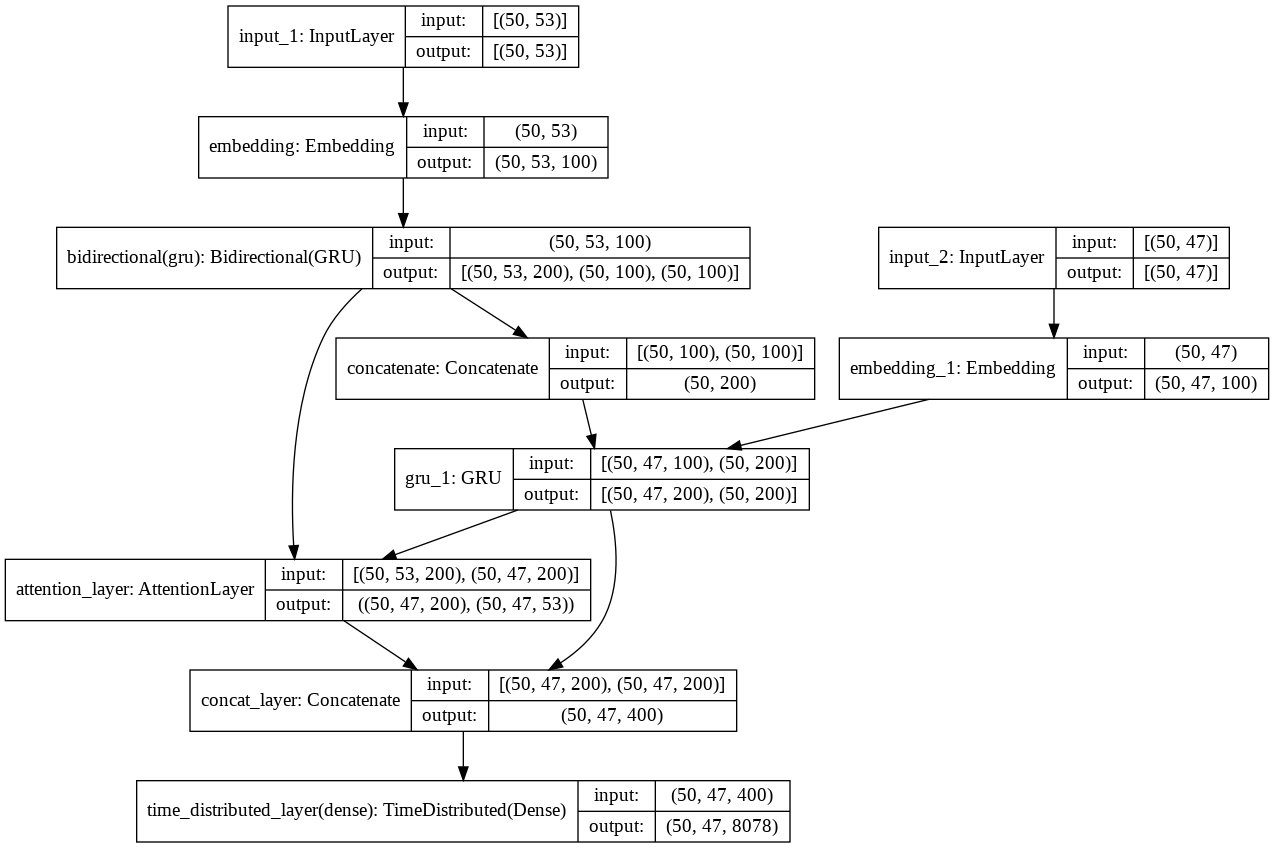

In [24]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image(retina=True, filename='model.png')

In [25]:
# Start training
epochs = 200
history = model.fit_generator(generator = generate_batch(input_tensor_train, target_tensor_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(input_tensor_val, target_tensor_val, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/200
32/32 [==============================] - 73s 2s/step - loss: 6.0487 - acc: 0.4613 - val_loss: 4.1529 - val_acc: 0.4799
Epoch 2/200
32/32 [==============================] - 72s 2s/step - loss: 3.7753 - acc: 0.4850 - val_loss: 3.7209 - val_acc: 0.4955
Epoch 3/200
32/32 [==============================] - 72s 2s/step - loss: 3.4995 - acc: 0.5033 - val_loss: 3.6628 - val_acc: 0.5113
Epoch 4/200
32/32 [==============================] - 72s 2s/step - loss: 3.4217 - acc: 0.5198 - val_loss: 3.6395 - val_acc: 0.5270
Epoch 5/200
32/32 [==============================] - 72s 2s/step - loss: 3.3627 - acc: 0.5356 - val_loss: 3.6143 - val_acc: 0.5387
Epoch 6/200
32/32 [==============================] - 74s 2s/step - loss: 3.3068 - acc: 0.5419 - val_loss: 3.5890 - val_acc: 0.5419
Epoch 7/200
32/32 [==============================] - 72s 2s/step - loss: 3.2520 - acc: 0.5444 - val_loss: 3.5634 - val_acc: 0.5439
Epoch 8

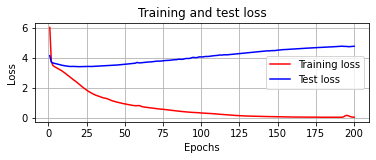

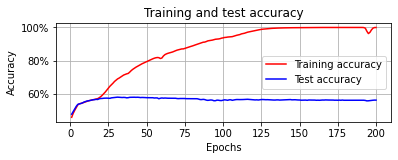

In [26]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(val_loss_values) + 1)
import matplotlib.pyplot as plt
%matplotlib inline 

plt.subplot(211)
plt.plot(epochs, history.history['loss'], 'r', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

plt.subplot(212)
plt.plot(epochs, history.history['acc'], 'r', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Test accuracy')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

In [0]:
# Inference model
batch_size = 1

# Encoder (Inference) model
encoder_inf_inputs = Input(batch_shape=(batch_size, max_length_inp,), name='encoder_inf_inputs')
enc_inf_emb = enc_emb_layer(encoder_inf_inputs)
# Encode the input sequence to get the "Context vectors"
encoder_inf_out, encoder_inf_fwd_state, encoder_inf_back_state = encoder_gru(enc_inf_emb)
encoder_model = Model(inputs=encoder_inf_inputs, outputs=[encoder_inf_out, encoder_inf_fwd_state, encoder_inf_back_state])

# Decoder (Inference) model
decoder_inf_inputs = Input(batch_shape=(batch_size, 1,), name='decoder_word_inputs')
encoder_inf_outputs = Input(batch_shape=(batch_size, max_length_inp, 2*latent_dim), name='encoder_inf_outputs')
decoder_init_state = Input(batch_shape=(batch_size, 2*latent_dim), name='decoder_init')
# Get the embeddings of the decoder sequence
dec_inf_emb= dec_emb_layer(decoder_inf_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_inf_out, decoder_inf_state = decoder_gru(dec_inf_emb, initial_state=decoder_init_state)
attn_inf_out, attn_inf_states = attn_layer([encoder_inf_outputs, decoder_inf_out])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_inf_out, attn_inf_out])
# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_inf_pred = TimeDistributed(decoder_dense)(decoder_inf_concat)
# Final decoder model
decoder_model = Model(inputs=[encoder_inf_outputs, decoder_init_state, decoder_inf_inputs],
                        outputs=[decoder_inf_pred, attn_inf_states, decoder_inf_state])

In [28]:
# Encoder model summary
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_inf_inputs (InputLay [(1, 53)]                 0         
_________________________________________________________________
embedding (Embedding)        multiple                  925400    
_________________________________________________________________
bidirectional (Bidirectional multiple                  121200    
Total params: 1,046,600
Trainable params: 121,200
Non-trainable params: 925,400
_________________________________________________________________


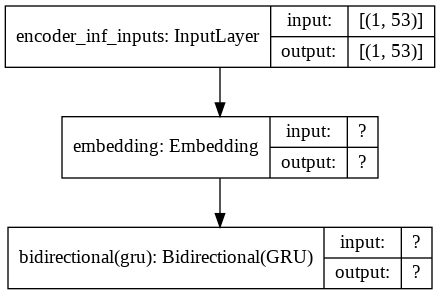

In [29]:
plot_model(encoder_model, show_shapes=True, show_layer_names=True, to_file='encoder_model.png')
Image(retina=True, filename='encoder_model.png')

In [30]:
# Decoder model summary
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_word_inputs (InputLayer [(1, 1)]             0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         multiple             807800      decoder_word_inputs[0][0]        
__________________________________________________________________________________________________
decoder_init (InputLayer)       [(1, 200)]           0                                            
__________________________________________________________________________________________________
gru_1 (GRU)                     multiple             181200      embedding_1[1][0]                
                                                                 decoder_init[0][0]         

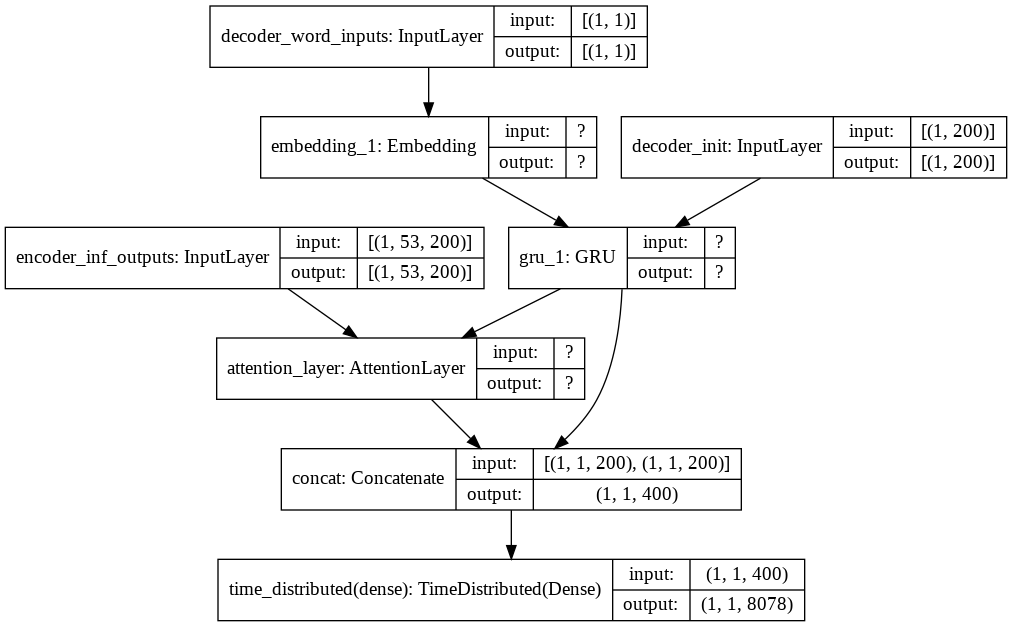

In [31]:
plot_model(decoder_model, show_shapes=True, show_layer_names=True, to_file='decoder_model.png')
Image(retina=True, filename='decoder_model.png')

In [0]:
def decode_sequence_with_k_beam_search(input_seq, k = 2):
    enc_outs, enc_fwd_state, enc_back_state = encoder_model.predict(input_seq)
    states_value = np.concatenate([enc_fwd_state, enc_back_state], axis=-1)
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = targ_lang.word_index['<start>']
    output, attent, states = decoder_model.predict([enc_outs, states_value, target_seq])
    sampled_token_index =  np.argsort(-output[0, -1, :])
    candidates = list()
    for idx in sampled_token_index[:k]:
        candidates.append([[idx], [[idx, attent]], [states], -np.log(output[0, -1, idx])])
    for l in range(max_length_targ):
        all_candidates = list()
        for i in range(len(candidates)):
            seq, atten, stas, score = candidates[i]
            target_seq = np.zeros((1,1))
            target_seq[0, 0] = seq[-1]
            output_tokens, attention, states_value = decoder_model.predict([enc_outs, stas[-1], target_seq])
            sampled_token_indices =  np.argsort(-output_tokens[0, -1, :])
            for index in sampled_token_indices[:k]:
                candidate = [seq + [index], atten + [[index, attention]], stas + [states_value], score - np.log(output_tokens[0, -1, index])]
                all_candidates.append(candidate)
        ordered = sorted(all_candidates, key=lambda item:item[-1])
        candidates = ordered[:k]
        if candidates[0][0][-1] == targ_lang.word_index['<end>']:
            break
    return candidates

In [0]:
# Function takes a tokenized sentence and returns the words
def sequence_to_text(index_word, tensor):
    # Looking up words in dictionary
    words = ' '.join(index_word.get(t) for t in tensor if t != 0)
    return(words)

In [34]:
!wget "https://www.wfonts.com/download/data/2014/06/01/simhei/simhei.zip"
!unzip "simhei.zip"
!mv SimHei.ttf /content

--2020-06-10 13:41:00--  https://www.wfonts.com/download/data/2014/06/01/simhei/simhei.zip
Resolving www.wfonts.com (www.wfonts.com)... 104.225.219.210
Connecting to www.wfonts.com (www.wfonts.com)|104.225.219.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10546298 (10M) [application/octetstream]
Saving to: ‘simhei.zip’

simhei.zip          100%[===================>]  10.06M  6.39MB/s    in 1.6s    

2020-06-10 13:41:03 (6.39 MB/s) - ‘simhei.zip’ saved [10546298/10546298]

Archive:  simhei.zip
  inflating: chinese.simhei.ttf      
  inflating: SimHei.ttf              
  inflating: sharefonts.net.txt      
mv: 'SimHei.ttf' and '/content/SimHei.ttf' are the same file


In [0]:
import os
import numpy as np
from numpy import *
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.font_manager as fm
path = '//content/SimHei.ttf'
fontprop = fm.FontProperties(fname=path, size=10)
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

def plot_attention_weights(encoder_inputs, attention_weights, index_word_inp, index_word_targ, base_dir, filename=None):
    """
    Plots attention weights
    :param encoder_inputs: Sequence of word ids (list/numpy.ndarray)
    :param attention_weights: Sequence of (<word_id_at_decode_step_t>:<attention_weights_at_decode_step_t>)
    :param en_id2word: dict
    :param fr_id2word: dict
    :return:
    """

    if len(attention_weights) == 0:
        print('Your attention weights was empty. No attention map saved to the disk. ' +
              '\nPlease check if the decoder produced  a proper translation')
        return

    mats = []
    dec_inputs = []
    for dec_ind, attn in attention_weights:
        mats.append(attn.reshape(-1))
        dec_inputs.append(dec_ind)
        #print(len(attention_weights))
    attention_mat = np.transpose(np.array(mats))
    #print(attention_mat.shape)
    fig, ax = plt.subplots(figsize=(16, 16))
    ax.imshow(attention_mat[:len(trim_zeros(encoder_inputs.ravel())),:])
    ax.set_xticks(np.arange(len(trim_zeros(dec_inputs))))
    ax.set_yticks(np.arange(len(trim_zeros(encoder_inputs.ravel()))))

    ax.set_yticklabels([index_word_inp[inp] for inp in trim_zeros(encoder_inputs.ravel())],fontproperties=fontprop)
    ax.set_xticklabels([index_word_targ[inp] for inp in trim_zeros(dec_inputs)])

    ax.tick_params(labelsize=24)
    ax.tick_params(axis='x', labelrotation=90)

    if not os.path.exists(os.path.join(base_dir, 'results')):
        os.mkdir(os.path.join(base_dir, 'results'))
    if filename is None:
        plt.savefig(os.path.join(base_dir, 'results', 'attention.png'))
    else:
        plt.savefig(os.path.join(base_dir, 'results', '{}'.format(filename)))

In [0]:
# Make predictions on the training dataset
train_gen = generate_batch(input_tensor_train, target_tensor_train, batch_size = 1)

Input Source sentence: 因此 ， 我们 不 应该 寻求 在 一 夜间 废除 整个 社会 保障 体系 ， 因为 那 会 伤害 到 那些 依靠 政府 提供 的 福利 过活 的 人 。
Actual   Target  Translation: thus , we should not seek to abolish the social safety net overnight because that would harm those who have grown dependent on government provided welfare .
Predicted Target Translation: thus , we should not seek to abolish the social safety net overnight because that would harm those who have grown dependent on government provided welfare .


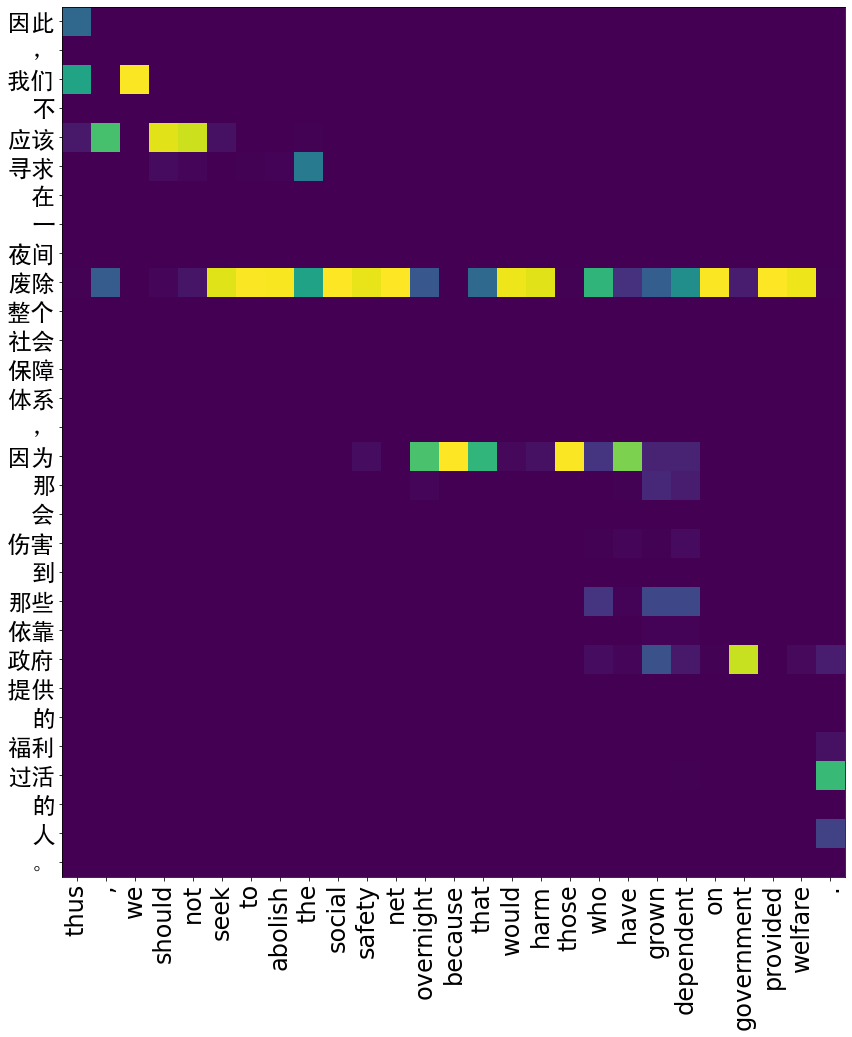

In [37]:
# Pass a source sentence and then compare the predicted output to actual output
(input_seq, actual_output), _ = next(train_gen)
candidates = decode_sequence_with_k_beam_search(input_seq, 3)
print('Input Source sentence:', sequence_to_text(index_word_inp, input_seq[0].tolist()))
print('Actual   Target  Translation:', sequence_to_text(index_word_targ, actual_output[0][1:].tolist()))
print('Predicted Target Translation:', sequence_to_text(index_word_targ, candidates[0][0][:-1]))
# Attention plotting
plot_attention_weights(input_seq, candidates[0][1][:-1], index_word_inp, index_word_targ, base_dir=r"/content/drive/My Drive/NLP/NMT", filename='attention_{}.png'.format(sequence_to_text(index_word_targ, candidates[0][0][:-1])[0:10]))

In [38]:
from nltk.translate.bleu_score import sentence_bleu
reference = [[token for token in sequence_to_text(index_word_targ, actual_output[0][1:].tolist()).split()]]
test = [token for token in sequence_to_text(index_word_targ, candidates[0][0][:-1]).split()]
score = sentence_bleu(reference, test)
print('Test - Predicted Target Translation:', test)
print('Reference - Actual Target Translation:', reference)
print('Bleu score:',score)

Test - Predicted Target Translation: ['thus', ',', 'we', 'should', 'not', 'seek', 'to', 'abolish', 'the', 'social', 'safety', 'net', 'overnight', 'because', 'that', 'would', 'harm', 'those', 'who', 'have', 'grown', 'dependent', 'on', 'government', 'provided', 'welfare', '.']
Reference - Actual Target Translation: [['thus', ',', 'we', 'should', 'not', 'seek', 'to', 'abolish', 'the', 'social', 'safety', 'net', 'overnight', 'because', 'that', 'would', 'harm', 'those', 'who', 'have', 'grown', 'dependent', 'on', 'government', 'provided', 'welfare', '.']]
Bleu score: 1.0


In [39]:
train_gen = generate_batch(input_tensor_train, target_tensor_train, batch_size = 1)
N_samples = train_samples
scores = [0]*N_samples
for i in range(N_samples):
    (input_seq, actual_output), _ = next(train_gen)
    candidates = decode_sequence_with_k_beam_search(input_seq)
    reference = [[token for token in sequence_to_text(index_word_targ, actual_output[0][1:].tolist()).split()]]
    test = [token for token in sequence_to_text(index_word_targ, candidates[0][0][:-1]).split()]
    scores[i] = sentence_bleu(reference, test)
    print('Sample: {} in total number of {}\n'.format(i, N_samples))
    print('Input Source sentence:', sequence_to_text(index_word_inp, input_seq[0].tolist()))
    print('Actual Target Translation:', sequence_to_text(index_word_targ, actual_output[0][1:].tolist()))
    print('Predicted Target Translation:', sequence_to_text(index_word_targ, candidates[0][0][:-1]))
    print('Bleu score:',scores[i])
    print("-------------------------------------------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------------------------------------------")
print("Average Bleu score: {}/{} = {}".format(sum(scores),N_samples,sum(scores)/N_samples))

Sample: 0 in total number of 1600

Input Source sentence: 因此 ， 我们 不 应该 寻求 在 一 夜间 废除 整个 社会 保障 体系 ， 因为 那 会 伤害 到 那些 依靠 政府 提供 的 福利 过活 的 人 。
Actual Target Translation: thus , we should not seek to abolish the social safety net overnight because that would harm those who have grown dependent on government provided welfare .
Predicted Target Translation: thus , we should not seek to abolish the social safety net overnight because that would harm those who have grown dependent on government provided welfare .
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 1 in total number of 1600

Input Source sentence: 那个 男人 无耻地 遗弃 了 妻儿 ， 另 寻 新欢 。
Actual Target Translation: the man shamelessly abandoned his wife and child for another woman .
Predicted Target Translation: the man shamelessly abandoned his wife and child for another woman .
Bleu score: 1.0
---------------------------------------------------------

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


流式输出内容被截断，只能显示最后 5000 行内容。
-------------------------------------------------------------------------------------------------------------------------
Sample: 525 in total number of 1600

Input Source sentence: 简言之 ， 您 拥有 在 此处 放置 抽象 层 的 空间 ， 可以 实现 为 两 个 按 顺序 应用 的 xslt 样式 表 。
Actual Target Translation: in short , you have room for another layer of abstraction here , implemented as two xslt stylesheets to be applied in sequence .
Predicted Target Translation: in short , you have room for another layer of abstraction here , implemented as two xslt stylesheets to be applied in sequence .
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 526 in total number of 1600

Input Source sentence: 在 听证会 上 ， 参议员 约翰 麦凯恩 将其 描述 为 列车 残骸 ， 并 指责 洛 马在做 一 件 糟糕 的 工作 。
Actual Target Translation: at the hearing , senator john mccain described it as a train wreck and accused lockheed martin of doing an abysmal job .
Pre

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Sample: 1239 in total number of 1600

Input Source sentence: 中国 成功 地 爆炸 了 第一 颗 原子弹 ， 在 全世界 引起 了 巨大 的 反响 。
Actual Target Translation: china s successful explode of a bomb arose huge response all over the world .
Predicted Target Translation: china has successfully exploded the first a bomb , which aroused great attention and echo .
Bleu score: 0.37991784282579627
-------------------------------------------------------------------------------------------------------------------------
Sample: 1240 in total number of 1600

Input Source sentence: 火车 在 晚点 运行 但 坐 了 二 个 小时 火车 穿越 南 澳大利亚 沙漠 的 35 个 土著 居民 的 孩子 似乎 对此 毫不 介意 。
Actual Target Translation: the train was running late , but the 35 aboriginal children who had travelled for two hours through the south australian desert to meet it did not seem to mind .
Predicted Target Translation: the train was running late , but the 35 aboriginal children who had travelled for two hours through the south australian desert to meet it did not seem to mind .

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Sample: 1542 in total number of 1600

Input Source sentence: 锆石 饰品 应 存放 小心 ， 因为 虽然 这个 古老 的 宝石 难 面 筹码 可以 研磨 。
Actual Target Translation: zircon jewelry should be stored carefully because although this ancient gem is hard , facets can abrade and chip .
Predicted Target Translation: over time they abrade the paint , allow oxidation to begin , and cause tiny rust spots in your paint .
Bleu score: 0.6606328636027614
-------------------------------------------------------------------------------------------------------------------------
Sample: 1543 in total number of 1600

Input Source sentence: 不 好 的 方法 用 缩写 表示 枚举 数据 不 是 个 好 办法 ， 因为 这样 用户 就 无法 判断 该 用 哪 一 个 值了 。
Actual Target Translation: bad it is a bad idea to abbreviate enumerations the user will have no idea which value to use .
Predicted Target Translation: bad it is a bad idea to abbreviate enumerations the user will have no idea which value to use .
Bleu score: 1.0
---------------------------------------------------------------------

In [0]:
# Make predictions on the Test dataset
test_gen = generate_batch(input_tensor_val, target_tensor_val, batch_size = 1)

Input Source sentence: 服用 脚 擦伤 药 及 皮肤 过敏 药 会 不 会 推迟 女性 月经 的 来临 ？
Actual Target Translation: take crural abrade medicine and skin allergy medicine to you can defer the advent of female menstruation ?
Predicted Target Translation: won t be pregnant. but if crural abrade medicine is external use medicine , can not take .


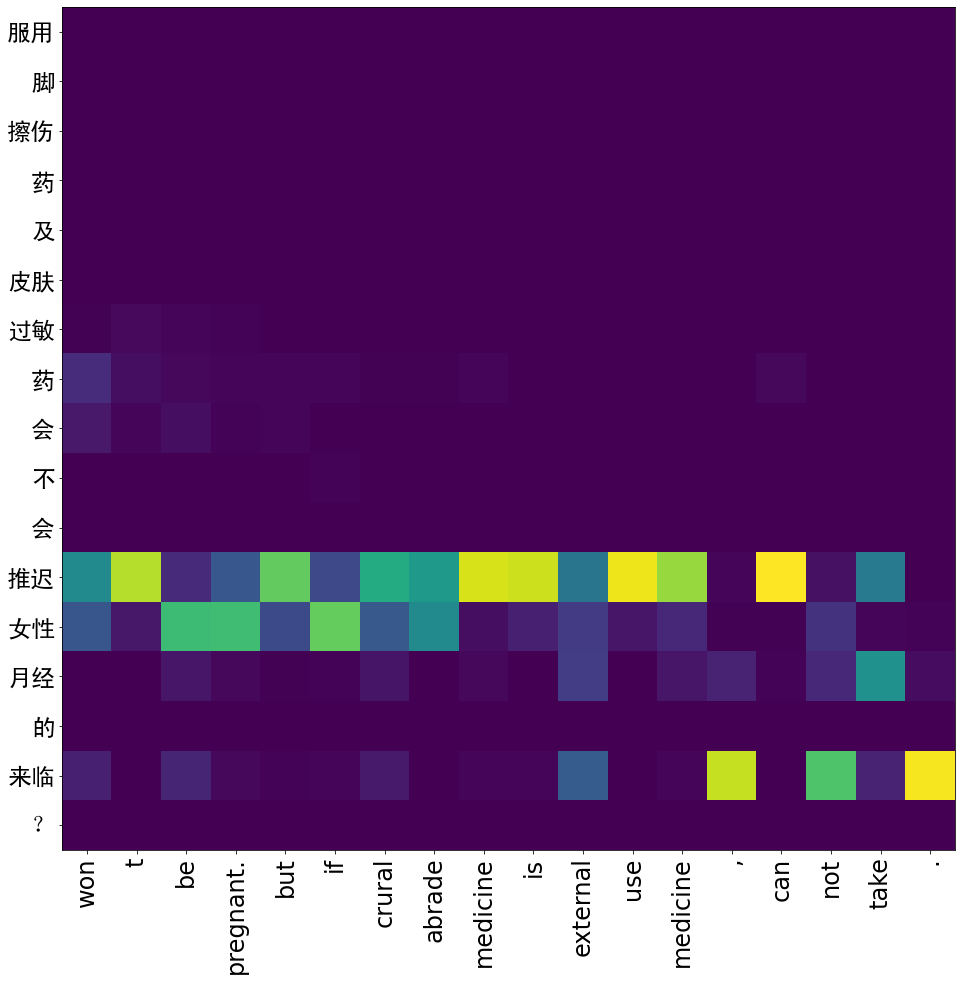

In [41]:
(input_seq, actual_output), _ = next(test_gen)
candidates = decode_sequence_with_k_beam_search(input_seq)
print('Input Source sentence:', sequence_to_text(index_word_inp, input_seq[0].tolist()))
print('Actual Target Translation:', sequence_to_text(index_word_targ, actual_output[0][1:].tolist()))
print('Predicted Target Translation:', sequence_to_text(index_word_targ, candidates[0][0][:-1]))
# Attention plotting
plot_attention_weights(input_seq, candidates[0][1][:-1], index_word_inp, index_word_targ, base_dir=r"/content/drive/My Drive/NLP/NMT", filename='attention_{}.png'.format(sequence_to_text(index_word_targ, candidates[0][0][:-1])[0:10]))

In [42]:
test_gen = generate_batch(input_tensor_val, target_tensor_val, batch_size = 1)
N_samples = val_samples
scores = [0]*N_samples
for i in range(N_samples):
    (input_seq, actual_output), _ = next(test_gen)
    candidates = decode_sequence_with_k_beam_search(input_seq)
    reference = [[token for token in sequence_to_text(index_word_targ, actual_output[0][1:].tolist()).split()]]
    test = [token for token in sequence_to_text(index_word_targ, candidates[0][0][:-1]).split()]
    scores[i] = sentence_bleu(reference, test)
    print('Sample: {} in total number of {}\n'.format(i, N_samples))
    print('Input Source sentence:', sequence_to_text(index_word_inp, input_seq[0].tolist()))
    print('Actual Target Translation:', sequence_to_text(index_word_targ, actual_output[0][1:].tolist()))
    print('Predicted Target Translation:', sequence_to_text(index_word_targ, candidates[0][0][:-1]))
    print('Bleu score:',scores[i])
    print("-------------------------------------------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------------------------------------------")
print("Average Bleu score: {}/{} = {}".format(sum(scores),N_samples,sum(scores)/N_samples))

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Sample: 0 in total number of 400

Input Source sentence: 服用 脚 擦伤 药 及 皮肤 过敏 药 会 不 会 推迟 女性 月经 的 来临 ？
Actual Target Translation: take crural abrade medicine and skin allergy medicine to you can defer the advent of female menstruation ?
Predicted Target Translation: won t be pregnant. but if crural abrade medicine is external use medicine , can not take .
Bleu score: 0.22250253290431038
-------------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Sample: 1 in total number of 400

Input Source sentence: 高盛 告诉 投资者 组成 cdo 的 合成 证券 阿巴卡斯 是 由 独立 的 抵押品 管理人 aca 公司 挑选 的 。
Actual Target Translation: it told investors that the securities bundled together to form the cdo , known as abacus , had been selected by an independent collateral manager , aca .
Predicted Target Translation: rubber of the press of using to the abacus of the information of the information .
Bleu score: 0.35317637446547284
-------------------------------------------------------------------------------------------------------------------------
Sample: 2 in total number of 400

Input Source sentence: 但是 ， 因为 我 的 谈话 更 增加 它 对 整个 野胡 一 族 的 厌恶 ， 它 倒 觉得 自己 心神不宁 起来 ， 这 种 情况 是 它 以前 从来 都 不曾 碰到 过 的 。
Actual Target Translation: but as my discourse had increased his abhorrence of the whole species , so he found it gave him a disturbance in his mind to which he was wholly a stranger before .
Predicted Target Translation: but it was no longer i don t have to a great effect , in no one

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Sample: 3 in total number of 400

Input Source sentence: 他 是 一 位 颇 具 奇妙 创造力 的 作家 ， 在 小说 中 实验性 尝试 非线性 的 叙述 和 荒诞 的 写作 手法 。
Actual Target Translation: he was a creative fantastic writer , and experimented with nonlinear narrative and absurdist techniques in his fiction .
Predicted Target Translation: he was in the united states in the united states in the early of the world in this is abuzz .
Bleu score: 0.3123939936920256
-------------------------------------------------------------------------------------------------------------------------
Sample: 4 in total number of 400

Input Source sentence: 她 经常 极端地 辱骂 我 和 我 的 兄弟 姐妹 ， 我 记得 她 这么 说道 ， 一 次 ， 在 我 生日 那 天 ， 她 给我 留言 说 希望 我 染上 疾病 。
Actual Target Translation: she s always been extremely abusive of me and my siblings , she said , as i recall . once , on my birthday , she left me a message wishing that i get a disease .
Predicted Target Translation: she dared to my in her to change the , so i have aboard the , and i have been very , and that